**Abstract**: Comcast is notorious for sub-par customer service and despite repeated promises to improve, they continue to fall short. In October of 2016, the FCC fined them 2.3 million dollars after receiving over 1000 consumer complaints. This notebook contains customer complaint data retrieved from Kaggle's public dataset.

**Goal**: The goal of this analysis is to further understand customer complaint data in order to influence future business decisions.

**Methods**:
- Step 1: Understand the business and the objective for analysis.
- Step 2: Retrieve/import the data
- Step 3: Explore and clean the data (EDA)
- Step 4: Build visualizations
- Step 5: Communicate results

In [1]:
import numpy as np                          #arrays/computing
import pandas as pd                         #data pre-processing and analysis
import matplotlib.pyplot as plt             #plotting
import seaborn as sns                       #statistical graphing
import re                                   #regular expressions
from os import path                         #os dependent functionality
from wordcloud import WordCloud, STOPWORDS  #wordcloud
from nltk.corpus import stopwords           #natural language toolkit
from PIL import Image                       #image loader

df = pd.read_csv('../input/comcastcomplaints/comcast_consumeraffairs_complaints.csv')

df.head()

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


In [2]:
df.tail()

,author,posted_on,rating,text
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package..."
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ..."
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...
5658,"John of Lilburn, GA","Feb. 19, 2006",0,"I have had AT&T/Comcast services, digital TV, ..."


In [3]:
#Display size of dataset
print(df.shape)

(5659, 4)


Important data points include the **rating**, the **location**, the **date**, and the **text** data. Therefore an outline for further analysis is as follows:

- Step 1. Visualize and count the rating data in the 'rating' column.
- Step 2. Visualize and count the location data in the 'author' column.
- Step 3. Plot the timeseries data from the 'posted_on' column.
- Step 4. Process and visualize the natural language from the 'text' column.

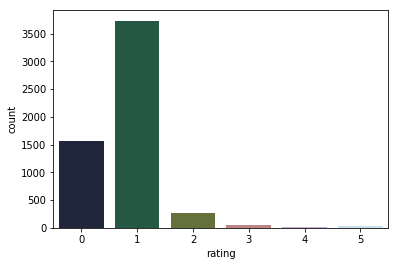

In [4]:
#Visualize rating data
sns.countplot(data=df,x='rating',palette='cubehelix')

This data makes sense because we are analyzing data that contains customer complaints so we would expect a high number of low ratings. Because a rating of '3' could be described as neutral and a rating > 3 is positive; we will want to clean this data to include ratings that are less than or equal to 2.

In [5]:
#Sum total reviews
Positive_reviews = int(df['rating'].loc[df['rating'] >= 3].count())
Negative_reviews = int(df['rating'].loc[df['rating'] < 3].count())
print('There are a total of ' + str(Positive_reviews) + ' positive reviews and a total of ' + str(Negative_reviews) + ' negative reivews.')

There are a total of 105 positive reviews and a total of 5554 negative reivews.


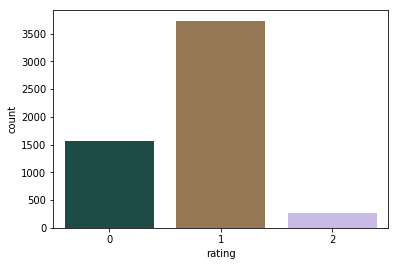

In [6]:
#Clean data and re-plot
df = df.loc[df.rating < 3]
sns.countplot(data=df,x='rating',palette='cubehelix')

In [7]:
print('There are ' + str(Negative_reviews) + ' total negative reviews.')

There are 5554 total negative reviews.


In [8]:
#Visualize the location data
df['state'] = df['author'].str.extract(r'(AL|Alabama|AK|Alaska|AZ|Arizona|AR|Arkansas|CA|California|CO|Colorado|CT|Connecticut|DE|Delaware|FL|Florida|GA|Georgia|HI|Hawaii|ID|Idaho|IL|Illinois|IN|Indiana|IA|Iowa|KS|Kansas|KY|Kentucky|LA|Louisiana|ME|Maine|MD|Maryland|MA|Massachusetts|MI|Michigan|MN|Minnesota|MS|Mississippi|MO|Missouri|MT|Montana|NE|Nebraska|NV|Nevada|NH|New Hampshire|NJ|New Jersey|NM|New Mexico|NY|New York|NC|North Carolina|ND|North Dakota|OH|Ohio|OK|Oklahoma|OR|Oregon|PA|Pennsylvania|RI|Rhode Island|SC|South Carolina|SD|South Dakota|TN|Tennessee|TX|Texas|UT|Utah|VT|Vermont|VA|Virginia|WA|Washington|WV|West Virginia|WI|Wisconsin|WY|Wyoming)')
df.state.value_counts()

FL            751
CA            549
GA            401
IL            371
PA            317
             ... 
IA              1
New Jersey      1
Oregon          1
AK              1
Georgia         1
Name: state, Length: 63, dtype: int64

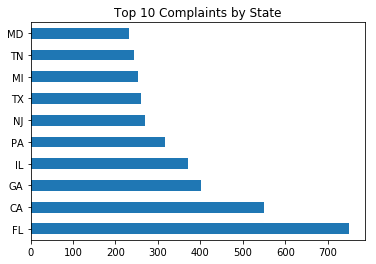

In [9]:
# Top 10 states with the most complaints
topTen = pd.value_counts(df['state'].values, sort=True).head(10)
topTen.plot.barh(title="Top 10 Complaints by State", x="Number of complaints", y="States")

From the graph above, you can see that Florida sent in the most amount of negative complaints followed by California, then Georgia.

In [10]:
# Extract year from 'posted_on' column
df['year'] = df['posted_on'].str.extract(r'([1-3][0-9]{3})')
df.year.value_counts()

2015    1452
2016     807
2014     754
2009     460
2008     441
2010     415
2012     409
2011     347
2013     309
2007     106
2006      34
2004      10
2003       6
2001       2
2000       1
2002       1
Name: year, dtype: int64

We can see from the extracted data that customers sent in the most amount of complaints in 2015, and the past 3 years received the most amount of complaints.

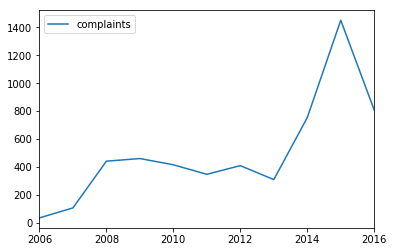

In [11]:
#Plot complaints as timeseries
timeseries = pd.DataFrame({
        'complaints': [34, 106, 441, 460, 415, 347, 409, 309, 754, 1452, 807]
    }, index=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])
lines = timeseries.plot.line()

In the plot above, we can see that customer complaints have increased in time over the past 10 years with a notable spike in complaints in 2015. Further analysis could be conducted to determine what caused this spike in 2015.

There are 6902007 words in the combination of all complaints.


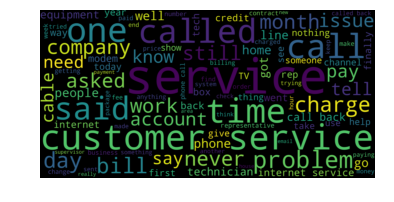

In [12]:
#Create wordcloud out of 'text' column

#Join complaints from all rows in text column
text = " ".join(str(complaint) for complaint in df.text)
print ("There are {} words in the combination of all complaints.".format(len(text)))

#create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Comcast", "even", "will", "now", "lot", "wow", "xfinity", "us", "want", "going", "told"])
wordcloud = WordCloud(stopwords=stopwords, max_words=100, width=4000, height=2000, background_color="black").generate(text)

#show plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Common customer complaints: Service, customer service, bill, problem, call, called, charge

**Results and Conclusion**

**Results**:
- 5554 negative complaints: (>90%) of complaints rated as a '1' or a '0'
- Highest number of complaints by locations: Florida, California, Georgia.
- Steady increase in # of complaints over past 10 years. Most amount of complaints received in 2015.
- Common complaints: Customer service, billing.

**Conclusion**:
Customers that sent in the most amount of negative complaints were most likely to complain about issues relating to customer service or billing. There has been a steady rise in complaints received over the past 10 years and further analysis may need to be conducted to determine what caused a spike in complaints in 2015. Customer service locations in problematic states such as Florida, California, and Georgia may need to be addressed.